In [680]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import datetime
import numpy
from pandas.plotting import table 

In [681]:
colors = ['b','g','r','c','m','y','k']

In [682]:
def getFormattedDfFromTimeSeries(path):
    df = pd.read_csv(path)
    df = df.drop('Lat', 1).drop('Long', 1).drop('Province/State',1)
    df = df.groupby('Country/Region').sum().sort_values(by=getDT(today), ascending=False).T
    if 'Cruise Ship' in df.columns:
        df = df.drop('Cruise Ship', 1)
    return df

In [683]:
population = pd.read_csv('~/Downloads/PopulationByCountry.csv')
population['Population'] = population['Population'].str.replace(",","").astype(int)
population.loc[population['Name'] == 'United States','Name'] = 'US'
population.loc[population['Name'] == 'United Kingdom','Name'] = 'UK'

In [684]:
df_confirmed_all = pd.read_csv('../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv').drop('Lat', 1).drop('Long', 1)
df_confirmed = getFormattedDfFromTimeSeries('../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df_dead = getFormattedDfFromTimeSeries('../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
df_recovered = getFormattedDfFromTimeSeries('../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

In [685]:
df_active = df_confirmed.copy()
for col in df_confirmed.columns:
    df_active[col] = df_confirmed[col] - df_dead[col] - df_recovered[col]

In [686]:
def getDT(dt):
    if isinstance(dt, str):
        return dt
    return dt.strftime("%-m/%-d/%y")
def toDT(dt):
    return datetime.datetime.strptime(dt, "%m/%d/%y")
startdatetime = "1/22/20" # datetime.datetime(year=2020, month=1, day=22)
today = df_confirmed.index[-1]

In [687]:
mapping = {
    'Iran (Islamic Republic of)': 'Iran',
    'Korea, South': 'South Korea',
    'Russian Federation': 'Russia',
    'occupied Palestinian territory': 'Palestine',
    'Republic of Moldova': 'Moldova',
    'Macao SAR': 'Macau',
    'Hong Kong SAR': 'Hong Kong',
    'Saint Martin': 'St. Martin',
    'Taipei and environs': 'Taiwan',
    'Holy See': 'Vatican City',
    'Viet Nam': 'Vietnam',
}

#Mainland China

for countryName, oldCountryName in mapping.items():
    if oldCountryName in df_confirmed.columns and countryName in df_confirmed.columns:
        df_confirmed[countryName] += df_confirmed[oldCountryName]
        df_confirmed = df_confirmed.drop(oldCountryName, 1)
        
        df_death[countryName] += df_death[oldCountryName]
        df_death = df_death.drop(oldCountryName, 1)
        
        df_recovered[countryName] += df_recovered[oldCountryName]
        df_recovered = df_recovered.drop(oldCountryName, 1)
    
    if oldCountryName in population['Name'].values:
        population.loc[population['Name']==oldCountryName,'Name'] = countryName

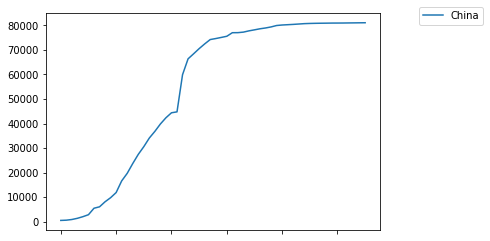

In [688]:
china = df_confirmed['China']
ax = china.plot()
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

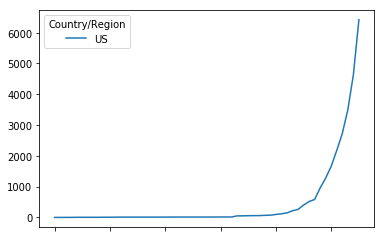

In [689]:
US = df_confirmed[['US']]
US.plot()

In [690]:
def generateAndPlotPrediction(x, y):
    f = lambda t,a,b: a * numpy.exp(b*t)
    popt, _ = curve_fit(f,  x,  y, p0=(4, 0.1))
    y_estimate = f(x, *popt)
    return lambda t: popt[0] * numpy.exp(popt[1] * t)
def generateAndPlotPredictionEstimates(x, y):
    f = lambda t,a,b: a * numpy.exp(b*t)
    popt, _ = curve_fit(f,  x,  y, p0=(4, 0.1))
    y_estimate = f(x, *popt)
    return popt

In [691]:
def addToAx(df, ax, dataFor, moredays=0, withFit=True, fromCaseNum=0, color='b'):
    df_from_case_num = df[df > fromCaseNum]
    x = np.linspace(1, len(df_from_case_num), len(df_from_case_num))
    y = df_from_case_num.values
    f = generateAndPlotPrediction(x, y)
    x2 = np.linspace(1, len(df_from_case_num) + moredays, len(df_from_case_num) + moredays)
    ax.plot(x, y, color + '-', label='data for {}'.format(dataFor))
    if withFit:
        ax.plot(x2, np.ceil(f(x2)), color + '--', label='fit for {}'.format(dataFor))
def plotCountries(df, start, end, savefilename='', moredays=0, logy=False, titlePH='confirmed', withFit=True, fromCaseNum=0):
    fig = plt.figure()
    ax = plt.subplot(111)
    for i, countryName in enumerate(df.T[start:end].T.columns):
        if countryName == 'Others':
            continue
        addToAx(df[countryName], ax, countryName, moredays=moredays, withFit=withFit, fromCaseNum=fromCaseNum, color=colors[i])
    if moredays > 0:
        plt.title('number of {} infected (COVID-19) -- from day 0 of infection in country with {} cases -- {} day prediction'.format(titlePH, fromCaseNum, moredays))
    else:
        plt.title('number of {} infected (COVID-19) -- from day 0 of infection in country with {} cases'.format(titlePH, fromCaseNum))

    if logy:
        ax.set_yscale('log')
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    if savefilename:
        plt.savefig(savefilename, bbox_extra_artists=(lgd,), bbox_inches='tight')
def plotState(US_all, stateName, savefig='', moredays=0, withFit=True, fromCaseNum=0, logy=False):
    stateDf = US_all[
        US_all['Province/State'].str.contains(stateName)
    ].set_index('Province/State').T.sum(axis=1).T
    fig = plt.figure()
    ax = plt.subplot(111)
    addToAx(
        stateDf, 
        ax,
        stateName,
        moredays=moredays, 
        withFit=withFit, 
        fromCaseNum=fromCaseNum, 
        color=colors[1]
    )
    if logy:
        ax.set_yscale('log')
    plt.title("{} Infected Num".format(stateName))
    plt.tight_layout()
    if savefig != '':
        plt.savefig(savefig, bbox_inches='tight')

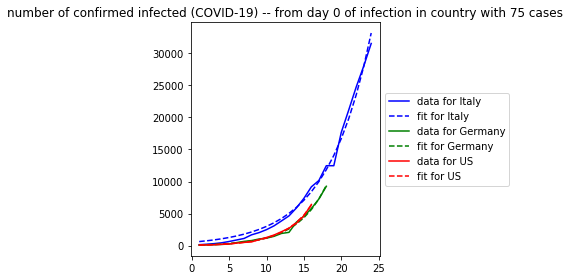

In [725]:
plotCountries(df_confirmed.T.iloc[[1, 5, 7]].T, 0, 3, 
              'Italy.Germany.US.png',
              moredays=0, 
              logy=False, 
              fromCaseNum=75)

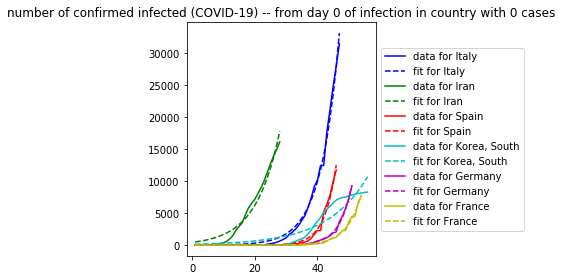

In [693]:
plotCountries(df_confirmed, 1,7, logy=False, fromCaseNum=0)

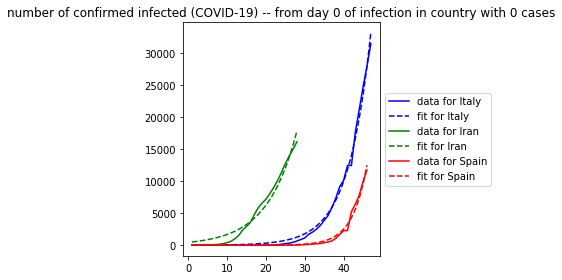

In [694]:
plotCountries(df_confirmed, 1,4, 'SK.Iran.Italy.png',moredays=0)

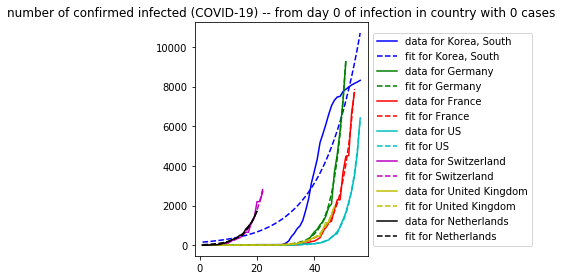

In [695]:
plotCountries(df_confirmed, 4,len(colors) + 4, '4.11.png', moredays=0)

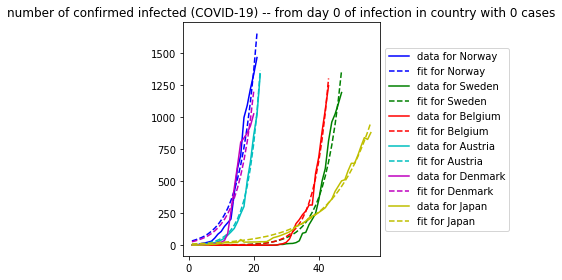

In [696]:
plotCountries(df_confirmed, len(colors) + 4, 2*len(colors) + 3, '12.18.png', moredays=0)

In [697]:
US_all = df_confirmed_all[df_confirmed_all['Country/Region'] == 'US']
US_all = US_all.drop('Country/Region', 1)

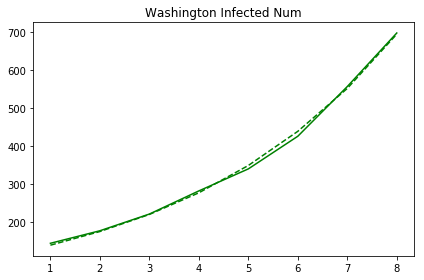

In [700]:
plotState(US_all, stateName='California', savefig='CA.png')

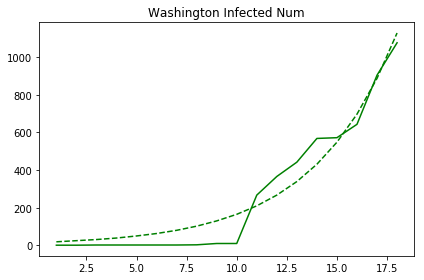

In [699]:
plotState(US_all, 'Washington', 'WA.png')

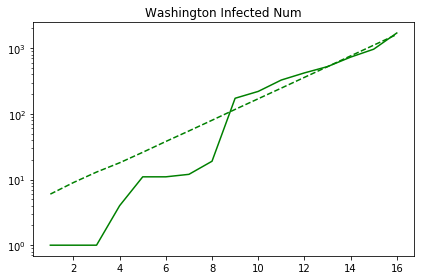

In [701]:
plotState(US_all, 'New York','NY.png',logy=True)

In [702]:
dfByPop = pd.merge(df_active.iloc[-1:].T.reset_index().rename(columns={'Country/Region':'Name'}), population, on='Name')
dfByPop = dfByPop.rename(columns={getDT(today):'InfectedNum'})
# dfByPop['Population'] = dfByPop['Population'].str.replace(",","").astype(int)
dfByPop['1 in X'] = (dfByPop['Population'] / dfByPop['InfectedNum']).replace([np.inf, -np.inf], np.nan).dropna(how="all").astype(int)
dfByPop['% Have It'] = (100 * dfByPop['InfectedNum'] / dfByPop['Population']).round(4)

success
            Name  InfectedNum    1 in X
0          Italy        26062    2319.0
1    Switzerland         2669    3242.0
2         Norway         1459    3715.0
3          Spain        10187    4589.0
4        Denmark         1019    5684.0
5        Austria         1328    6781.0
6   Korea, South         6832    7504.0
7         Sweden         1182    8544.0
8         France         7539    8658.0
9        Germany         9166    9140.0
10       Belgium         1232    9407.0
11   Netherlands         1663   10303.0
12       Finland          311   17815.0
13      Portugal          444   22965.0
14        Israel          326   26550.0
15        Greece          374   27869.0
16     Singapore          152   38489.0
17      Malaysia          622   52035.0
18            US         6296   52573.0
19       Lebanon          114   59872.0
20     Australia          424   60141.0
21      Slovakia           72   75828.0
22        Canada          464   81340.0
23         Chile          201   

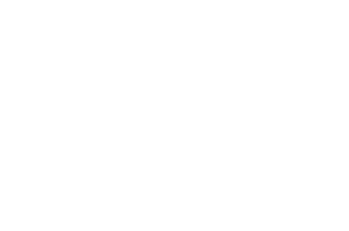

In [703]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

tableToPlot = dfByPop[dfByPop['Population'] > 5000000].sort_values(by='1 in X').reset_index()[['Name', 'InfectedNum', '1 in X']]

tableToPlot[:25].to_html('table.tmp.html')
title = """<h3>Active Cases By Country, 1 In X people currently have it</h3>"""
with open('table.tmp.html', 'r') as f:
    with open('table.html', 'w') as f2:
        f2.write(title + "\n")
        f2.write(f.read())
import subprocess
output = subprocess.call(
    'wkhtmltoimage -f png --width 0 table.html table.activebycountry.1inx.wkh.png', shell=True)

if output != 0:
    print("Try installing wkhtmltoimage/pdf: brew cask install wkhtmltopdf")
else:
    print("success")
    print(tableToPlot[:25])

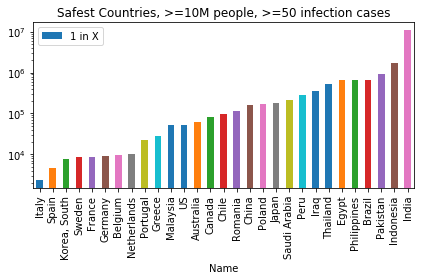

In [704]:
toPlot = dfByPop[dfByPop['Population'] >= 10e6]
toPlot = toPlot[toPlot['InfectedNum'] >= 100]
toPlot = toPlot.sort_values(by='1 in X')
toPlot[['Name', '1 in X']].plot.bar(x='Name', y='1 in X',logy=True)
plt.title('Safest Countries, >=10M people, >=50 infection cases')
plt.tight_layout()
# plt.savefig('safestCountries.1inx.png', bbox_inches='tight')

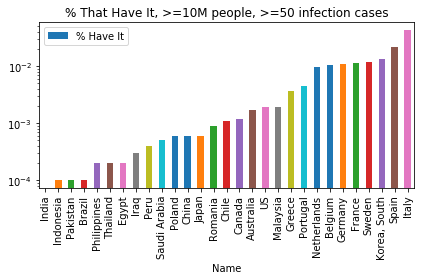

In [705]:
toPlot = dfByPop[dfByPop['Population'] >= 10e6]
toPlot = toPlot[toPlot['InfectedNum'] >= 100]
toPlot = toPlot.sort_values(by='% Have It')
toPlot[['Name', '% Have It']].plot.bar(x='Name', y='% Have It',logy=True)
plt.title('% That Have It, >=10M people, >=50 infection cases')
plt.tight_layout()
# plt.savefig('safestCountries.percenthaveit.png', bbox_inches='tight')

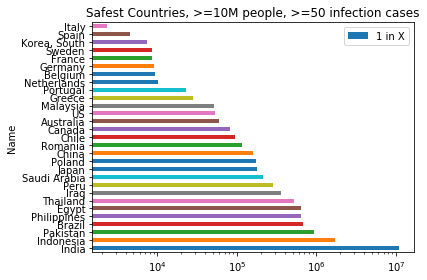

In [706]:
toPlot = dfByPop[dfByPop['Population'] >= 10e6]
toPlot = toPlot[toPlot['InfectedNum'] >= 100]
toPlot = toPlot.sort_values(by='1 in X')
toPlot[['Name', '1 in X']].iloc[::-1].plot(kind='barh', x='Name', y='1 in X', logx=True)
ax.invert_xaxis()
plt.title('Safest Countries, >=10M people, >=50 infection cases')
plt.tight_layout()
# plt.savefig('safestCountries.2.png')

In [707]:
notChina = df_confirmed.drop('China', 1)
notChina = pd.DataFrame(data=notChina.sum(axis=1).values, columns=['NumInfected'], index=notChina.index)
notChina['delta'] = notChina.diff(axis=0)
notChina = notChina.iloc[1:]
notChina['secondDiv'] = notChina['delta'] / notChina['delta'].shift()
notChina = notChina.iloc[1:]

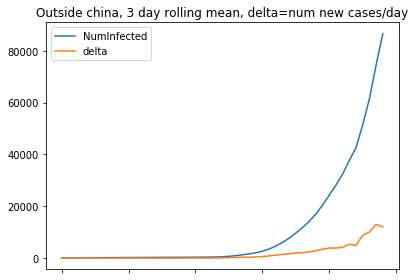

In [708]:
notChina[['NumInfected','delta']].rolling(3).mean().iloc[4:-1].plot()
plt.title("Outside china, 3 day rolling mean, delta=num new cases/day")
plt.tight_layout()
plt.savefig("outsidechina.firstderiv.png")

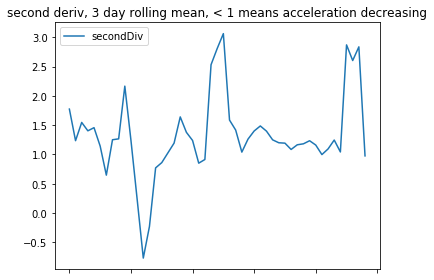

In [709]:
notChina[['secondDiv']].rolling(3).mean().iloc[4:-1].plot()
plt.title("second deriv, 3 day rolling mean, < 1 means acceleration decreasing")
plt.tight_layout()
# plt.savefig("outsidechina.secondderiv.png")

In [710]:
def predictForwardFromOthers(df, currentVal, inHowManyDays):
    avgT = 0
    avgC = 0
    for countryName in df.iloc[-1:][df.iloc[-1:] > currentVal].dropna(1).columns:
        if 'China' in countryName:
            continue
        previousValue = sum(df[countryName] > currentVal) + 1
        dfIncluding = df[countryName][-previousValue:]
        if (previousValue - 1) < inHowManyDays:
            continue
        previous, nextVal = dfIncluding.iloc[0], dfIncluding.iloc[inHowManyDays]
        avgT += (1 - (currentVal - previous)/currentVal) * (nextVal - currentVal)
        avgC += 1
    return avgT/avgC + currentVal, avgC

In [711]:
predictForwardFromOthers(df_confirmed, 4650, 2) # new york numbe rof cases

(6468.633978494624, 6)

In [712]:
predictForwardFromOthers(df_confirmed, 328, 4)

(821.2308106169297, 17)

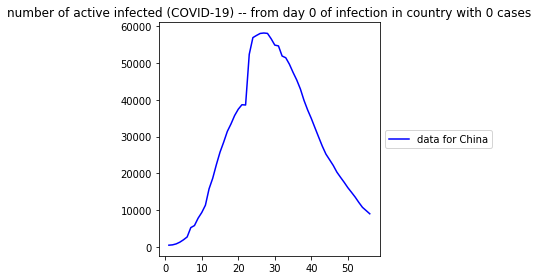

In [713]:
plotCountries(df_active, 0, 1, titlePH='active',withFit=False, savefilename='activeCasesChina.png')

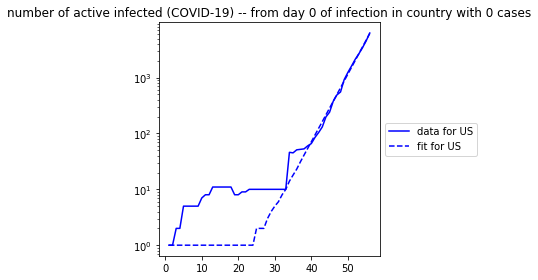

In [714]:
plotCountries(df_active, 7, 8, titlePH='active',withFit=True, logy=True, savefilename='us_active_logy.png')

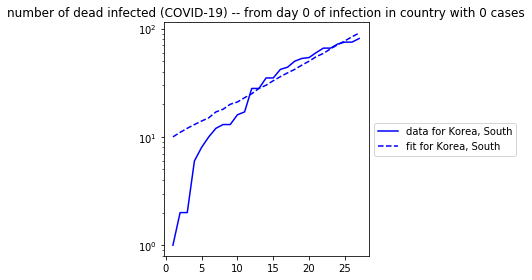

In [715]:
plotCountries(df_dead, 6, 7, titlePH='dead',withFit=True, logy=True, savefilename='us_dead_logy.png')

In [716]:
def plotStackedLine(df, title, numberOfCountries, savefigName=''):
    percentActiveDf =  df.div(df.sum(1), axis=0)
    plottingDf = percentActiveDf.T.sort_values(by=df_active.index[-1],ascending=False).iloc[:numberOfCountries].T
    plottingDf['Other'] = 1 - plottingDf.sum(axis=1)
    plottingDf.index = list(map(toDT, plottingDf.index))

    ax = plottingDf.plot.area()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    
    plt.title(title)

    if savefigName:
        plt.savefig(savefigName, bbox_extra_artists=(lgd,), bbox_inches='tight')

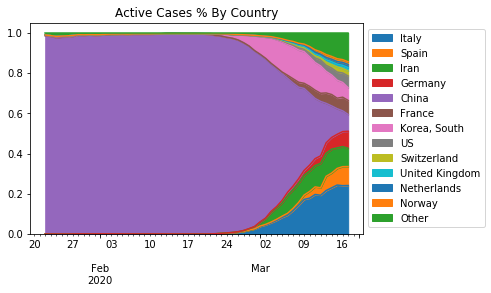

In [717]:
plotStackedLine(df_active, 'Active Cases % By Country', 12, 'stackedarea.active.all.png')

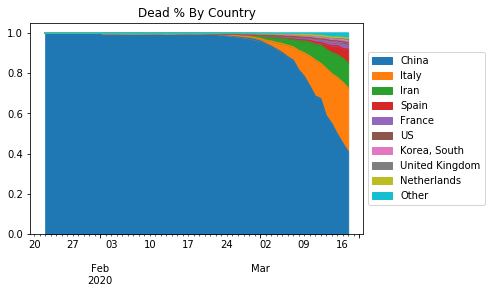

In [718]:
plotStackedLine(df_dead, 'Dead % By Country', 9, 'stackedarea.dead.all.png')

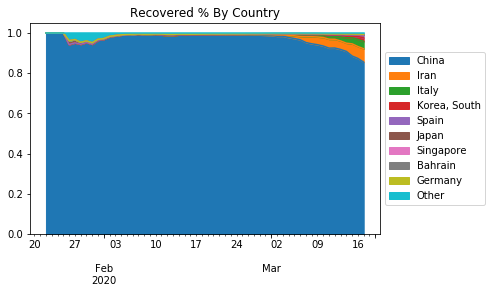

In [719]:
plotStackedLine(df_recovered, 'Recovered % By Country', 9, 'stackedarea.recovered.all.png')

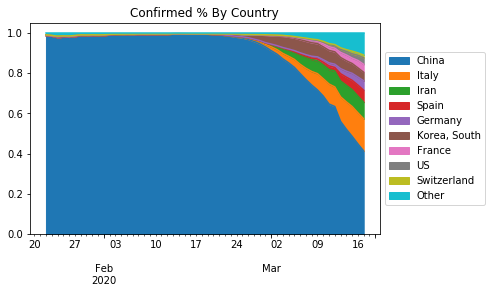

In [720]:
plotStackedLine(df_confirmed, 'Confirmed % By Country', 9, 'stackedarea.recovered.all.png')

In [741]:
italy = df_dead[['Italy']].rename(columns={'Italy':'Cum Num Dead'})
italy['new_dead'] = italy['Cum Num Dead'] - italy['Cum Num Dead'].shift(1)
italy['dead_per_minute'] = (24 * 60) / italy['new_dead']
italy = italy.iloc[1:].replace(np.inf, 0)

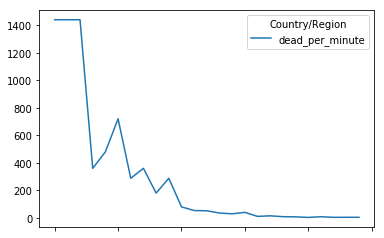

In [745]:
italy[['dead_per_minute']][italy['dead_per_minute']!=0].plot()

In [759]:
lastTwoDaysDeaths = df_dead.sum(axis=1).iloc[-2:]
secondsPerDeaths = int((24*60*60)/(lastTwoDaysDeaths.iloc[-1] - lastTwoDaysDeaths.iloc[0]))
print("There is one death per {} seconds in the world right now".format(secondsPerDeaths))

There is one death per 110 seconds in the world right now
